In [ ]:
# pip install -U imbalanced-learn

In [ ]:
# pip install lightgbm

In [ ]:
# Importing packages

# Preprocessing
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE, ADASYN, KMeansSMOTE, BorderlineSMOTE
from sklearn.experimental import enable_iterative_imputer #multistage imputation 위해서
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.decomposition import PCA


# Model related
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

# Others/misc
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import sklearn
import imblearn
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,precision_recall_curve,plot_confusion_matrix


print('Sklearn version:',sklearn.__version__)
print('Pandas version:',pd.__version__)
print('Imblearn version:',imblearn.__version__)

Sklearn version: 0.23.2
Pandas version: 1.1.5
Imblearn version: 0.7.0


In [ ]:
cd ./drive/My Drive/KUBIG/scania

In [ ]:
df = pd.read_csv('train.csv')
print('Dimension of dataset:',df.shape)
df.iloc[:5,:10]

Dimension of dataset: (60000, 171)


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002
0,neg,76698,na,2130706438,280,0,0,0,0,0
1,neg,33058,na,0,na,0,0,0,0,0
2,neg,41040,na,228,100,0,0,0,0,0
3,neg,12,0,70,66,0,10,0,0,0
4,neg,60874,na,1368,458,0,0,0,0,0


In [ ]:
df.groupby('class').count().iloc[:,1]
# Imbalanced: neg:pos = 59:1

class
neg    59000
pos     1000
Name: ab_000, dtype: int64

In [ ]:
df.dtypes.unique()
# object, int64 only

array([dtype('O'), dtype('int64')], dtype=object)

In [ ]:
df.dtypes.value_counts()

object    170
int64       1
dtype: int64

In [ ]:
# 결측치 비율 확인 
def miss(x):
    return(x.isnull().sum()/x.shape[0]*100).sort_values()

miss(df)

class     0.0
cn_009    0.0
co_000    0.0
cp_000    0.0
cq_000    0.0
         ... 
ba_006    0.0
ba_007    0.0
ba_008    0.0
ba_000    0.0
eg_000    0.0
Length: 171, dtype: float64

## 결측치 처리
1. 결측치 비율 20퍼 이상 컬럼 제거
2. 20퍼 이하
   - KNN Impute
   - MICE
   - SMOTE(KNN기반)
   - 단순대체(mean,median,mode)

### 불균형 자료 처리
-  SMOTE(KNN 기반)
- ADASYN(KNN 기반 + 비례추출)
- Complex sampling(Over + Under)

차원축소 or 피쳐 선택

In [ ]:
df1 = df.copy()

## Missing Data
1. Missing Completely at Random (MCAR)
- 'Missing' link is independent of observed & unobserved (no systematic differences)
- Missingness unrelated to each variables (unrealisticallly strong)

2. Missing at Random (MAR)
- Missingness not random but can be fully counted for by complete variables
- Impossible to statistically verify reasonableness needed to classify

3. Missing not at Random (MNAR)
- non-ignorable nonresponse
- Missingness related to the reason of its missing


=> assume MAR/MCAR for MICE


In [ ]:
df1 = df1.replace(to_replace='nan', value = np.NAN).replace(to_replace='na', value = np.NAN)
sum(miss(df1)>0)

169

Text(0, 0.5, '% of Missing')

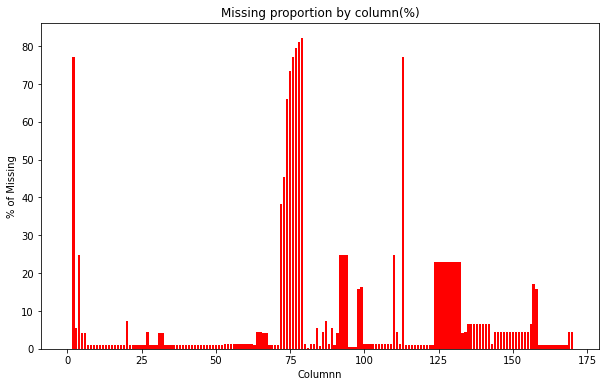

In [ ]:
miss_val_lst=list(df1.isna().sum())
col = list(df1.columns)

plt.figure(figsize=(10,6))
plt.bar([i for i in range(df1.shape[1])],[(i*100)/df1.shape[0] for i in miss_val_lst], color = 'r')
plt.title('Missing proportion by column(%)')
plt.xlabel('Columnn')
plt.ylabel('% of Missing')

In [ ]:
# 결측치 비율 확인 
over_20 = df1.columns[miss(df1) > 20]
print(len(over_20))
df1 = df1.drop(over_20, axis = 1)
print(sum(miss(df1)>0))
df1.head(1)

24
145


,class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,...,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000
0,neg,76698,NaN,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,0,469014,4239660,...,98822,11208,1608,220,240,6700214,NaN,10476,1226,267998,521832,428776,4015854,895240,26330,118,0,532,734,4122704,51288,0,532572,0,18,5330690,4732,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0


In [ ]:
Le = LabelEncoder()
Le.fit(df1['class'])
df1['class'] = Le.transform(df1['class'])
df1.groupby('class').count()

,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,...,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000
class,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,59000,13442,56127,44784,56841,56841,58333,58333,58333,58333,58333,58333,58333,58333,58333,58333,58396,58413,58413,55132,58401,58413,58401,58451,58401,58451,56654,58413,58413,58413,56841,56840,58334,58334,58334,58334,58334,58334,58334,58334,...,58317,58317,58317,44784,56653,58351,13442,58335,58335,58335,58335,58335,58335,58335,58335,58335,58335,45724,45724,45724,45724,45724,45724,45724,45724,45724,56838,56653,55516,55516,55516,55518,55517,55517,55516,55515,58351,56653,56651,56651
1,1000,229,538,355,659,659,996,996,996,996,996,996,996,996,996,996,959,958,958,468,957,958,957,960,957,960,623,958,958,958,659,659,995,995,995,995,995,995,995,995,...,996,996,996,355,623,958,229,996,996,996,996,996,996,996,996,996,996,468,468,468,468,468,468,468,468,468,659,623,476,476,476,476,476,476,476,476,958,623,623,623


In [ ]:
df1 = df1.apply(pd.to_numeric)
df1.dtypes.value_counts()
cols= df1.columns
#수치형으로 다 전환

In [ ]:
df_now = df1.copy() # reset df

# Defining Imputer
Iter = IterativeImputer(random_state=1, initial_strategy = 'median')
df_filled = pd.DataFrame(Iter.fit_transform(df_now), columns = cols)

In [ ]:
df_filled.to_csv('df_filled.csv')

In [ ]:
df_filled = pd.read_csv('df_filled.csv')

In [ ]:
# Imbalanced with ADASYN
X = df_filled.drop('class', axis = 1)
y = df_filled['class']

ada=ADASYN(random_state=42, n_neighbors = 5)
X_ada,y_ada=ada.fit_resample(X,y)
print('Resampled after ADASYN k =5', '%s' % Counter(y_ada))

sc = StandardScaler()
X_std = sc.fit_transform(X_ada)

Resampled after ADASYN k =5 Counter({1.0: 59067, 0.0: 59000})


Eigenvalues 
[3.99322249e+01 9.69264413e+00 6.89838198e+00 5.32998099e+00
 4.61510555e+00 3.36905138e+00 3.20332633e+00 3.00097489e+00
 2.99996631e+00 2.70959589e+00 2.55864591e+00 2.12269790e+00
 2.00518966e+00 1.97668772e+00 1.91806818e+00 1.71272241e+00
 1.69873643e+00 1.64614540e+00 1.59266014e+00 1.55095765e+00
 1.52126344e+00 1.48336877e+00 1.33138163e+00 1.27105591e+00
 1.23338637e+00 1.20607757e+00 1.14406152e+00 1.12324671e+00
 1.06889452e+00 1.04880785e+00 1.03396428e+00 1.01124995e+00
 1.00389904e+00 9.57628988e-01 9.86590483e-01 9.99714181e-01
 9.78993678e-01 9.27001388e-01 8.92537503e-01 9.46665422e-01
 8.87321074e-01 8.62881651e-01 8.30096683e-01 8.00267609e-01
 7.90473322e-01 7.54339273e-01 7.63558392e-01 7.21047610e-01
 7.06738992e-01 6.69781197e-01 6.73820368e-01 6.38335728e-01
 6.08409157e-01 5.70263460e-01 5.62982973e-01 5.12622553e-01
 5.00206617e-01 4.74736034e-01 4.85701111e-01 4.43328906e-01
 4.21445502e-01 4.19495524e-01 3.99825267e-01 3.86101734e-01
 3.70946973

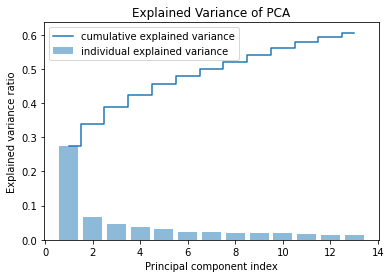

In [ ]:
# Explained variance ratio
# 고유값, 고유벡터 구하기
scov=np.cov(X_std.T)
eigen_vals, eigen_vecs=np.linalg.eig(scov)
print('Eigenvalues \n%s' %eigen_vals)

tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1,14), var_exp[:13], alpha=0.5, align='center',label='individual explained variance')
plt.step(range(1,14), cum_var_exp[:13], where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.title('Explained Variance of PCA')
plt.legend(loc='best')
plt.show()

In [ ]:
pca = PCA(n_components=5)
X_fin = pca.fit_transform(X_std)

X_train, X_test, y_train, y_test = train_test_split(X_fin, y_ada, test_size = 0.2, random_state = 42)

For Logistic Regression:
GS Best score: 0.908494179447142
Best params: {'C': 0.1}
Train accuracy: 0.9086635681238288
Test accuracy: 0.9102227492165664


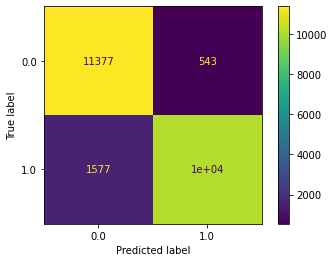

In [ ]:
#Logistic Regression
lr = LogisticRegression(random_state = 1, max_iter = 1000, penalty = 'l2')
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'C': param_range}]

gs = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='accuracy', cv=10)
gs = gs.fit(X_train, y_train)

print('For Logistic Regression:')
print('GS Best score:',gs.best_score_)
print('Best params:',gs.best_params_)

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Train accuracy:',clf.score(X_train,y_train))
print('Test accuracy:',clf.score(X_test, y_test))

plot_confusion_matrix(clf, X_test, y_test)
plt.show()

For Decision Tree:
GS Best score: 0.9701121249010984
Best params: {'max_depth': None}
Train accuracy: 1.0
Test accuracy: 0.97065300245617


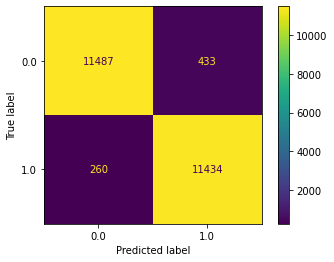

In [ ]:
#Decision Tree
dt = DecisionTreeClassifier(random_state = 1)
param_grid=[{'max_depth': [1, 2, 3, 4, 5, 6, 7,8,9,10, None]}]

gs = GridSearchCV(estimator=dt, param_grid=param_grid, scoring='accuracy', cv=10)
gs = gs.fit(X_train, y_train)

print('For Decision Tree:')
print('GS Best score:',gs.best_score_)
print('Best params:',gs.best_params_)

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Train accuracy:',clf.score(X_train,y_train))
print('Test accuracy:',clf.score(X_test, y_test))

plot_confusion_matrix(clf, X_test, y_test)
plt.show()

In [ ]:
# Classification Tree
dtc = DecisionTreeClassifier(criterion='accuracy', max_depth=None, random_state=1)
dtc.fit(X_train, y_train)
y_train_pred = dtc.predict(X_train)  # Training accuracy
y_test_pred = dtc.predict(X_test)    # Test accuracy

In [ ]:
tree.plot_tree(dtc.fit(X_train,y_train))

For lightGBM:
GS Best score: 0.9673276601544518
Best params: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 30}
Train accuracy: 0.9738600150339323
Test accuracy: 0.9672651816718896


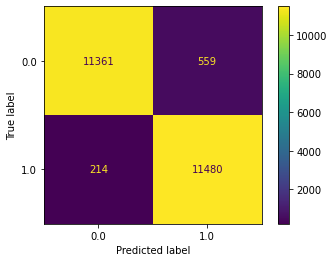

In [ ]:
#lightGBM
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [5, 10, 20, 30]
}
lgbm_ = lightgbm.LGBMClassifier(random_state=1,class_weight='balanced', n_jobs = 1)


gs = GridSearchCV(estimator=lgbm_, param_grid=param_grid, scoring='accuracy', cv=10)
gs = gs.fit(X_train, y_train)

print('For lightGBM:')
print('GS Best score:',gs.best_score_)
print('Best params:',gs.best_params_)

clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Train accuracy:',clf.score(X_train,y_train))
print('Test accuracy:',clf.score(X_test, y_test))

plot_confusion_matrix(clf, X_test, y_test)
plt.show()

In [ ]:
clf = lightgbm.LGBMClassifier(random_state=1,class_weight='balanced', n_jobs = 1, learning_rate = 0.1, n_estimators=200, num_leaves = 30)

In [ ]:
clf.fit(X_train, y_train)
clf.feature_importances_

array([1299, 1086, 1141, 1156, 1118])

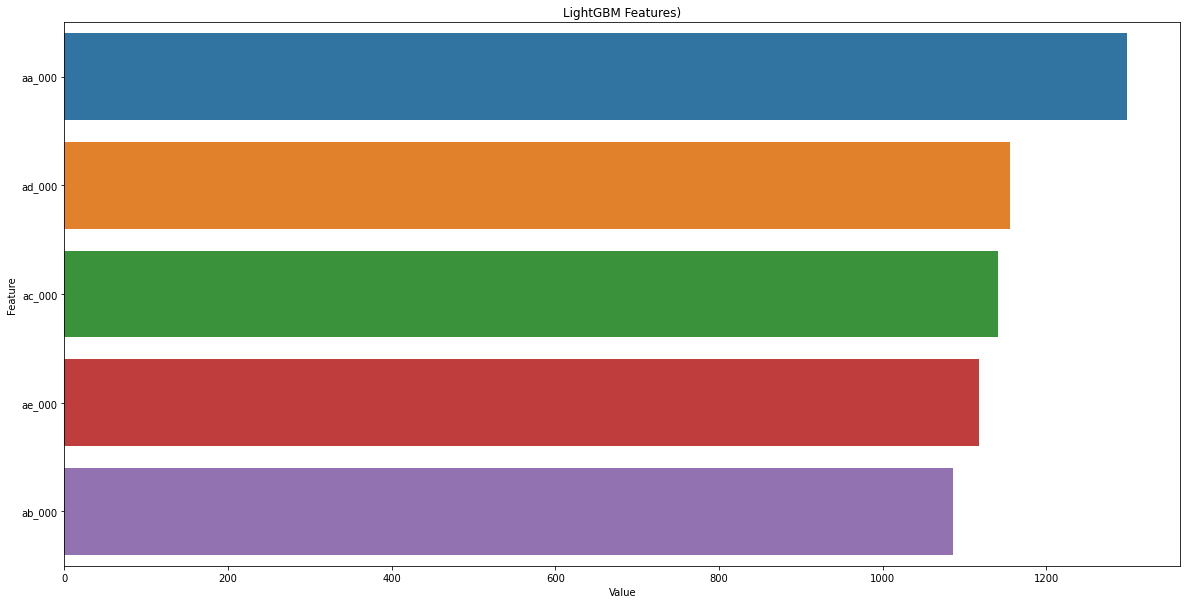

In [ ]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,df_filled.columns[2:])), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features)')
plt.show()